# MILESTONE 1

## -MODULE 1

#### Label/List classes

In [22]:
import os

root = "DATASET"
print("Exists:", os.path.exists(root))
print("Classes:", os.listdir(root))

Exists: True
Classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


#### Ensure balanced distribution and clean samples.
##### Ensure there is no corrupted images

In [2]:
from PIL import Image
import os

root = "DATASET"
bad = []

for cls in os.listdir(root):
    cls_dir = os.path.join(root, cls)
    if not os.path.isdir(cls_dir):
        continue
    for f in os.listdir(cls_dir):
        p = os.path.join(cls_dir, f)
        try:
            with Image.open(p) as im:
                im.verify()
        except:
            bad.append(p)

print("Corrupted files:", len(bad))
for p in bad:
    print(p)

Corrupted files: 0


#### Class distribution plot

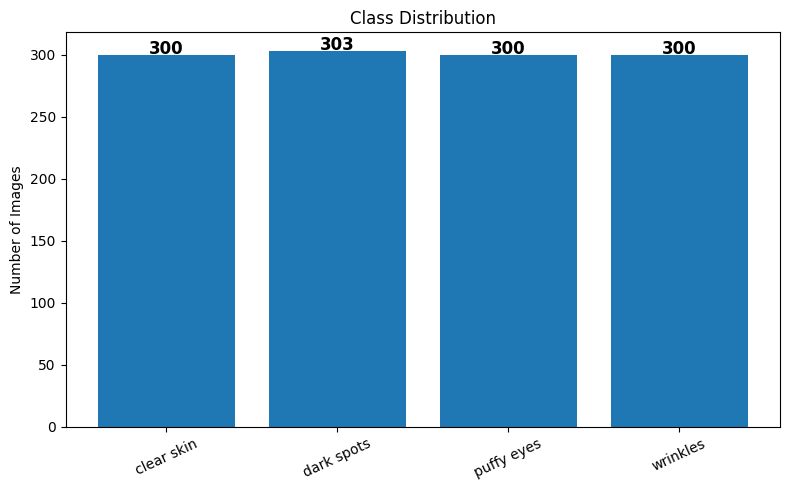

In [5]:
import matplotlib.pyplot as plt

root = "DATASET"
counts = {}

for cls in os.listdir(root):
    cls_path = os.path.join(root, cls)
    if os.path.isdir(cls_path):
        counts[cls] = len(os.listdir(cls_path))

classes = list(counts.keys())
vals = [counts[c] for c in classes]

plt.figure(figsize=(8,5))
bars = plt.bar(classes, vals)

# Add numbers above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 1,
             str(height),
             ha='center', fontsize=12, fontweight='bold')

plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

## -MODULE 2

In [12]:
import os, shutil, random, uuid
from pathlib import Path
import cv2
import numpy as np
import pandas as pd

ROOT = "DATASET"        # source
PROCESSED = "processed" # resized images
AUGMENTED = "augmented" # augmented images
OUTPUTS = "outputs"

for d in (PROCESSED, AUGMENTED, OUTPUTS):
    os.makedirs(d, exist_ok=True)

classes = sorted([d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))])
print("Classes:", classes)

Classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


#### Resize and normalize images (224x224).

In [15]:
TARGET_SIZE = (224, 224)  # (width, height)

def resize_image_save(src_path, dst_path, size=TARGET_SIZE):
    img = cv2.imread(src_path)
    if img is None:
        return False
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    cv2.imwrite(dst_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return True

errors = []
for cls in classes:
    src_dir = os.path.join(ROOT, cls)
    dst_dir = os.path.join(PROCESSED, cls)
    os.makedirs(dst_dir, exist_ok=True)
    for fname in os.listdir(src_dir):
        src_p = os.path.join(src_dir, fname)
        dst_p = os.path.join(dst_dir, fname)
        if not resize_image_save(src_p, dst_p):
            errors.append(src_p)

print("Resize complete. unreadable files:", len(errors))
if errors:
    os.makedirs(os.path.join(OUTPUTS, "corrupt"), exist_ok=True)
    for p in errors:
        shutil.copy(p, os.path.join(OUTPUTS, "corrupt", os.path.basename(p)))

# Returns float32 array in [0,1], shape (224,224,3)
def load_and_normalize(path, size=TARGET_SIZE):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if (img.shape[1], img.shape[0]) != size:  # width, height
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    img = img.astype("float32") / 255.0
    return img

Resize complete. unreadable files: 0


#### Apply image augmentation (flip, rotation, zoom).

In [17]:
import math
import random
import numpy as np
import cv2

def augment_simple_rgb(img, rotate_limit=20, scale_min=0.9, scale_max=1.1, p_flip=0.5):
    h, w = img.shape[:2]
    # flip
    if random.random() < p_flip:
        img = img[:, ::-1, :]

    # random rotation
    angle = random.uniform(-rotate_limit, rotate_limit)
    # random scale (zoom)
    scale = random.uniform(scale_min, scale_max)

    M = cv2.getRotationMatrix2D((w/2, h/2), angle, scale)
    aug = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    # final resize/crop to TARGET_SIZE
    aug = cv2.resize(aug, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    return aug


=== CLASS: clear skin ===


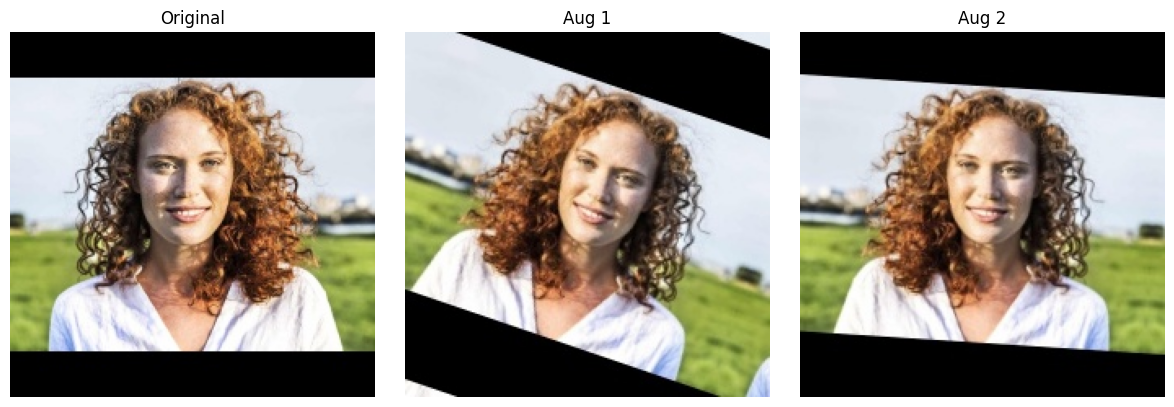


=== CLASS: dark spots ===


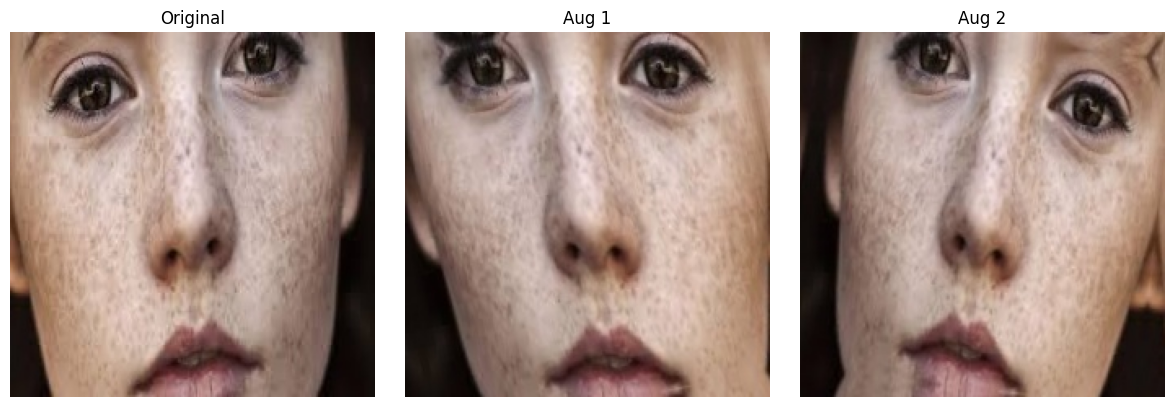


=== CLASS: puffy eyes ===


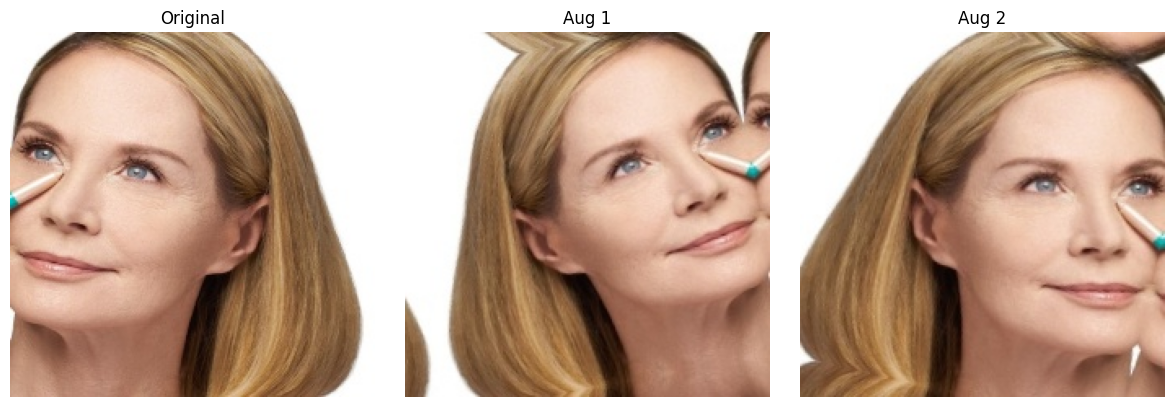


=== CLASS: wrinkles ===


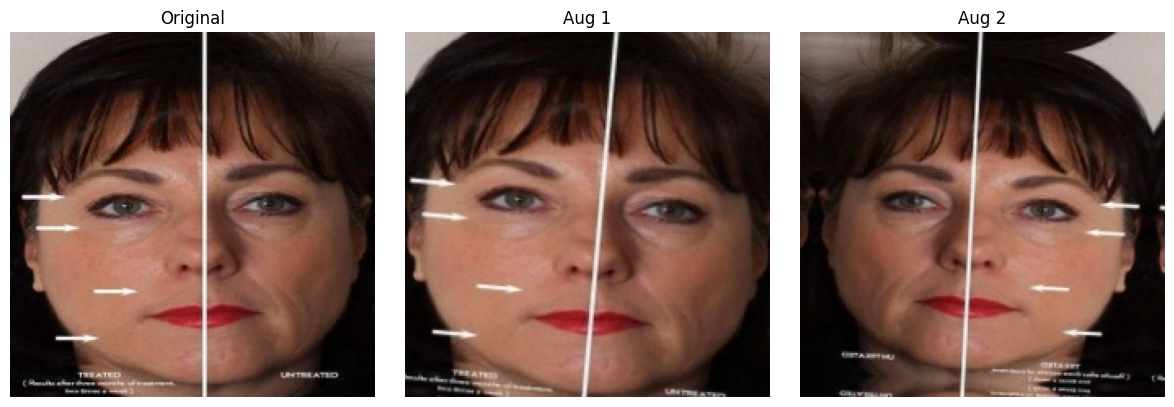

In [25]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_before_after_grid(processed_folder, augmented_folder, samples_per_class=2):
    classes = sorted(os.listdir(processed_folder))

    for cls in classes:
        print(f"\n=== CLASS: {cls} ===")

        proc_dir = os.path.join(processed_folder, cls)
        aug_dir  = os.path.join(augmented_folder, cls)

        # list all files
        proc_files = sorted([f for f in os.listdir(proc_dir)])
        aug_files  = sorted([f for f in os.listdir(aug_dir)])

        # pick N random samples per class
        selected = random.sample(proc_files, min(samples_per_class, len(proc_files)))

        for f in selected:
            base = os.path.splitext(f)[0]

            # original
            orig_path = os.path.join(proc_dir, f)
            orig_img = Image.open(orig_path)

            # find augmentations
            related_aug = [a for a in aug_files if a.startswith(base) and "aug" in a]

            # total columns = 1 original + number of augmentations
            total_cols = 1 + len(related_aug)
            plt.figure(figsize=(4 * total_cols, 4))

            # show original
            plt.subplot(1, total_cols, 1)
            plt.imshow(orig_img)
            plt.title("Original")
            plt.axis("off")

            # show aug images
            for idx, a in enumerate(related_aug, start=2):
                aug_img = Image.open(os.path.join(aug_dir, a))

                plt.subplot(1, total_cols, idx)
                plt.imshow(aug_img)
                plt.title(f"Aug {idx-1}")
                plt.axis("off")

            plt.tight_layout()
            plt.show()


# Run: show 2 samples per class (change to 1, 3, 4, etc.)
show_before_after_grid("processed", "augmented", samples_per_class=1)

#### Encode class labels using one-hot encoding.

In [19]:
mapping = {cls: idx for idx, cls in enumerate(classes)}
pd.DataFrame(list(mapping.items()), columns=["class", "index"]).to_csv(os.path.join(OUTPUTS, "class_mapping.csv"), index=False)
print("Mapping saved:", mapping)

def to_one_hot(index, num_classes=len(classes)):
    arr = np.zeros(num_classes, dtype=int)
    arr[index] = 1
    return arr

Mapping saved: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}
